In [1]:
from datetime import datetime as dt
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, precision_recall_curve
from sklearn.pipeline import Pipeline as skl_Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imb_Pipeline

import pipeline_objects as po
from data_exploration_tools import make_evaluation_plots
from pipeline_objects import PrepData, MyTargetEncoder, MultipurposeEncoder, MyProbBuilder, AddNewFeatures
from feats_from_nlp import My_tfidf

In [2]:
database_info = po.build_dbase_info_dict('./database_info.txt')
data_retrieve = po.GetData(database_info)
df_orig = data_retrieve.load_data()

In [3]:
ohe_enc_feats = ['contest_mode', 'edited', 'adult_content', 'oc', 'reddit_media', 'selfpost',
             'video', 'distinguished',
            ]
target_enc_feats = ['content_categories', 'subreddit', 'weekday', 'post_hour']

drop_feats = ['final_upvotes', 'final_num_comments', 'how_sorted', 'upvotes', 'comments']

In [4]:
data_prep = PrepData(drop_feats = drop_feats)
df_prepped = data_prep.fit_transform(df_orig)

X = df_prepped.drop(columns = 'gilded')
y = df_prepped['gilded']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.25,
                                                    random_state=42,
                                                    stratify = y
                                                   )

## Dummy Classifier

In [5]:
dum = DummyClassifier(strategy = 'stratified')
dum.fit(X_train, y_train)

dum_predictions = dum.predict(X_test)

dum_prec = precision_score(y_test, dum_predictions)
dum_reca = recall_score(y_test, dum_predictions)

print('Precision is: {:.1f}%'.format(dum_prec*100))
print('Recall is: {:.1f}%'.format(dum_reca*100))

Precision is: 1.2%
Recall is: 1.4%


## Heuristic Classifier

Calculate fraction of posts which receive gilding when binning all data according to three predictive features:
* *subreddit* - the Subreddit in which the post was made
* *post_hour* - the hour of day, in utc time, the post was made
* *upvote_rate* - the total number of upvotes a post receives divided by its age, in minutes (both measured at the time of scraping)

Use these priors as binomial probabilities for making predictions.

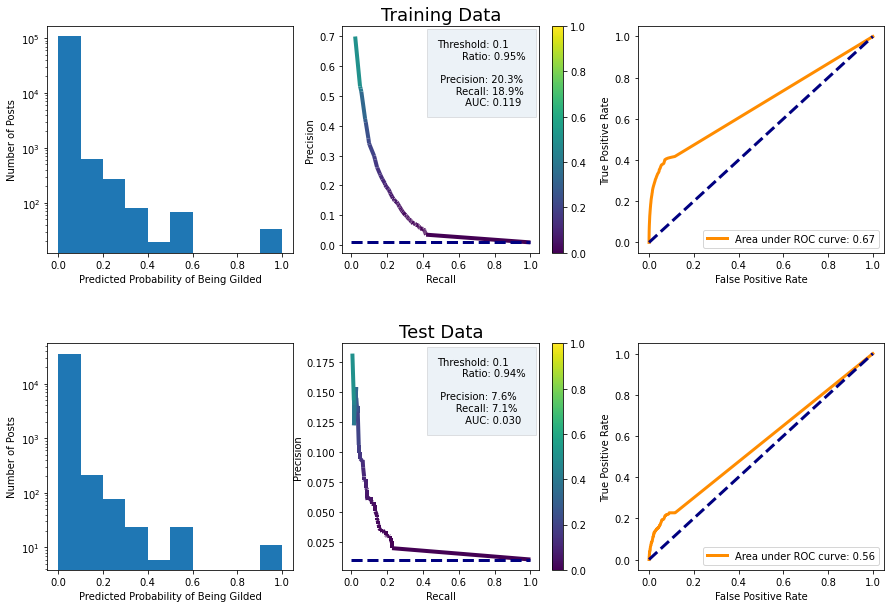

In [6]:
priors_clf = MyProbBuilder(['subreddit', 'post_hour'], ['upvote_rate'])
priors_clf.fit(X_train, y_train)

thresh = 0.1
make_evaluation_plots(priors_clf, X_train, y_train, X_test, y_test, thresh = thresh)

The performance is poor, but better than random guessing (compare precision/recall to Dummy Classifier above). Unsurprisingly, this model does not generalize well (unsurprising because it is literally memorizing the training data). This can give a decent baseline for comparison, however. A successful model must show significant improvement over this.

I will also experiment with using the historical gilding fraction as a feature for more complex models.

## XGBoost Classifier

Build a full suite of features from the data and train an XGBoost model on them.

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  2.6min finished
/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: 

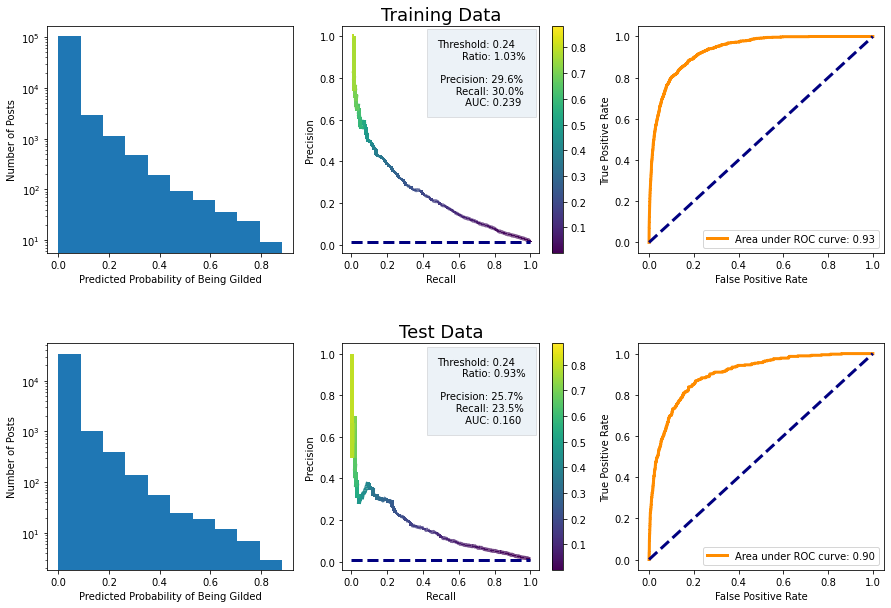

,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.166597,0.178465,0.112571,0.149265,0.149308,0.151241,0.022271,1


In [5]:
current_ratio = y_train.sum()/(~y_train).sum()

xgb = XGBClassifier(eval_metric = 'aucpr', use_label_encoder = False, verbosity = 0 )

#rmf = RandomForestClassifier(n_jobs = -1)
over = SMOTE()
under = RandomUnderSampler()

tfidf_num_feats = 500
num_pca_vars = 0
tfidf = My_tfidf(target_column_name = 'title',
                 tfidf_num_feats = tfidf_num_feats,
                 num_pca_vars = num_pca_vars
                )
num_nlp_vars = min(num_pca_vars, tfidf_num_feats)

# Need to build this out so that this part of the pipe appends the post-PCA() array
# to the originial df
# Might need to build my own custom class here? takes only title column
# and replaces it w/ ~400 columns of tfidf stuff
# nlp_pipe = skl_Pipeline([('tfidf', vectorizer),
#                          ('todense', )
#                          ('pca', PCA(svd_solver = 'randomized',
#                                      n_components = 400
#                                     )),
#                          ('append', )
#                         ])

resample_pipe = imb_Pipeline([('over', over),
                              ('under', under),
                              ('model', xgb)
                             ])

pipe = skl_Pipeline([('new_feats', AddNewFeatures()),
                     ('categ_enc', MultipurposeEncoder(ohe_feats = ohe_enc_feats, 
                                                       target_feats = target_enc_feats,
                                                       target_how = 'additive_smoothing',
                                                      )),
                     ('tfidf', tfidf),
                     ('scaler', StandardScaler()),
                     #('decomp', PCA()),
                     ('resample_classify', resample_pipe)
                    ])


# https://xgboost.readthedocs.io/en/latest/parameter.html
parameters = {'resample_classify__model__eta':[0.25],
              'resample_classify__model__gamma':[2],
              'resample_classify__model__min_child_weight':[5],              
              'resample_classify__model__max_depth': [3],
              'resample_classify__model__max_delta_step': [10],
              'resample_classify__model__subsample': [1],
              'resample_classify__model__sampling_method': ['uniform'],
              'resample_classify__model__lambda': [10],
              'resample_classify__model__alpha': [0],
              'resample_classify__model__scale_pos_weight': [2],              
              'resample_classify__over__sampling_strategy': [current_ratio*1.01],
              'resample_classify__under__sampling_strategy': [current_ratio*1.01],              
              'categ_enc__target_weight': [0], 
             # 'decomp__n_components': [0.99],
              'new_feats__feat_names': [['Log_of_Features_Distance']],#,'Priors_Fractions']],
              'new_feats__weight': [3],
              'tfidf__tfidf_num_feats': [500],
              'tfidf__num_pca_vars': [0]
             }


clf = GridSearchCV(pipe,
                   parameters,
                   n_jobs = -1,
                   scoring = 'average_precision',
                   verbose = 1,
                   cv = 5
                  )
_ = clf.fit(X_train, y_train)

thresh = 0.24
make_evaluation_plots(clf, X_train, y_train, X_test, y_test, thresh = thresh)

cv_fits = pd.DataFrame(clf.cv_results_)
cv_fits.iloc[:,-8:].sort_values('rank_test_score', ascending = True)

In [8]:
#cv_fits.iloc[:,[-11,-3,-2,-1]].sort_values('rank_test_score', ascending = True)

In [9]:
#clf.best_params_

#### Feature importances:

In [6]:
cols = list(X_train.columns) + ['log_feature'] + ['tfidf_{}'.format(x) for x in range(500)]
#cols.remove('post_age')
cols.remove('title')
feat_imp = clf.best_estimator_['resample_classify']['model'].feature_importances_
top_vals = pd.Series(feat_imp, index = cols).sort_values(ascending = False)

try:
    words = clf.best_estimator_['tfidf'].tfidf_features
except:
    pass

try:
    is_tfidf_feat_mask = [idx[:5] == 'tfidf' for idx in top_vals.index]
    top_words = top_vals.iloc[is_tfidf_feat_mask]
except:
    pass
    

In [7]:
top_vals.iloc[:25]

upvote_rate           0.062426
content_categories    0.058259
std_up_rate           0.047016
subreddit             0.042793
log_feature           0.041738
selfpost              0.037846
tfidf_441             0.034149
initial_silver        0.028530
reddit_media          0.028118
tfidf_497             0.027658
post_age              0.024919
tfidf_6               0.023527
distinguished_rate    0.022069
avg_up_rate           0.018179
comment_rate          0.017403
video                 0.014372
post_hour             0.013546
tfidf_1               0.013314
tfidf_348             0.012580
tfidf_445             0.012069
op_comment_rate       0.011768
weekday               0.011682
tfidf_417             0.011269
tfidf_7               0.011155
tfidf_454             0.010797
dtype: float32

In [8]:
words_importance = pd.DataFrame(top_words.sort_index().reset_index())
words_importance.columns = ['tfidf number', 'importance']
words_importance['word'] = words
nonzero_importances = words_importance[words_importance['importance'] > 0]

num_to_show = 20
top = words_importance.sort_values('importance', ascending = False).iloc[:num_to_show,[2,1]].reset_index(drop = True)
top.columns = pd.MultiIndex.from_product([['Top'], top.columns])
bottom = nonzero_importances.sort_values('importance', ascending = True).iloc[:num_to_show,[2,1]].sort_values('importance', ascending = False).reset_index(drop = True)
bottom.columns = pd.MultiIndex.from_product([['Bottom'], bottom.columns])

top_and_bottom = pd.concat([top,bottom], axis = 1)

print('{} words with nonzero feature importance. The top and bottom {} of these are:'.format(nonzero_importances.shape[0], num_to_show))

top_and_bottom



58 words with nonzero feature importance. The top and bottom 20 of these are:


Top              Bottom           
        word importance     word importance
0        saw   0.034149   better   0.005890
1        til   0.027658   travel   0.005885
2         tv   0.023527    power   0.005723
3         10   0.013314  probabl   0.005660
4       miss   0.012580    stock   0.005571
5     second   0.012069     date   0.005552
6       read   0.011269   offici   0.005488
7         vs   0.011155    adult   0.005362
8     sexual   0.010797   public   0.005358
9   redditor   0.010781   return   0.005291
10     insid   0.010325     bodi   0.005277
11       kid   0.010105      abl   0.005205
12      food   0.010019    space   0.005134
13     claim   0.009252   servic   0.004952
14   languag   0.009208      red   0.004784
15    releas   0.008774     joke   0.004688
16      king   0.008468   friend   0.004349
17   perfect   0.008408    pizza   0.004303
18      wait   0.008094    canva   0.004272
19      line   0.007898     citi   0.002835

/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


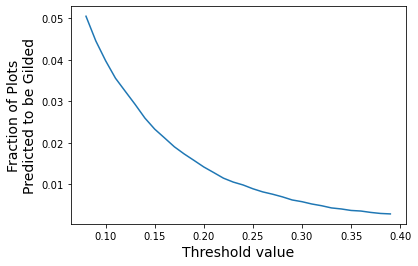

In [13]:
# Set thresh grid to check through
step = 0.01
upper = 0.4
lower = 0.08

probs = clf.predict_proba(X_test)
num_instances = len(probs)
thresh_vals = np.arange(lower, upper, step)
ratio = [sum([1 if prob > thresh else 0 for prob in probs[:,1]])/num_instances for thresh in thresh_vals]

fig, ax = plt.subplots(1,1)
ax.plot(thresh_vals, ratio)
ax.set_xlabel('Threshold value', fontsize = 14)
ax.set_ylabel('Fraction of Plots\nPredicted to be Gilded', fontsize = 14)
#ax.set_yscale('log')

plt.show()

#### Do my gilding probabilities correlate with other metrics of post success?

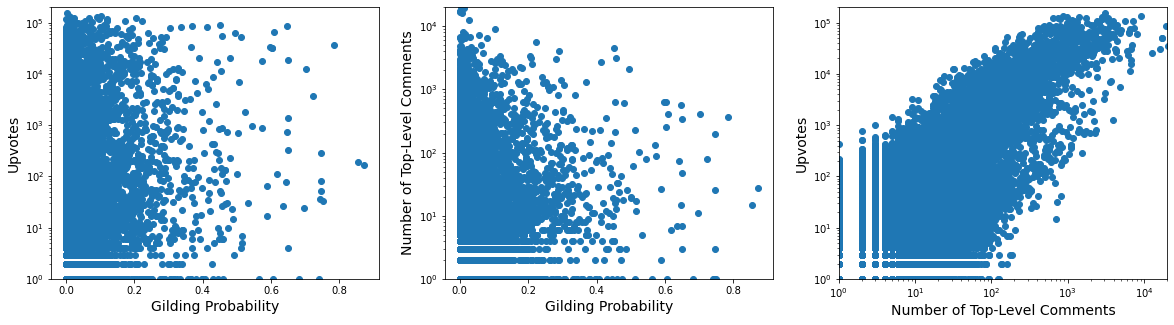

,final_num_comments,final_upvotes,gild_prob,gilded
final_num_comments,1.000000,0.561705,0.058606,0.032779
final_upvotes,0.561705,1.000000,0.136763,0.069411
gild_prob,0.058606,0.136763,1.000000,0.290406
gilded,0.032779,0.069411,0.290406,1.000000


In [14]:
outcomes = df_orig.iloc[X_test.index,:][['final_num_comments', 'final_upvotes']]
outcomes['gild_prob'] = pd.Series([x[1] for x in probs], index = X_test.index)
outcomes['gilded'] = y_test
outcomes = outcomes.astype(float)


fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (20,5))

ax1.scatter(outcomes['gild_prob'], outcomes['final_upvotes'])
ax1.set_ylabel('Upvotes', fontsize = 14)
ax1.set_xlabel('Gilding Probability', fontsize = 14)
ax1.set_yscale('log')
ax1.set_ylim([1,2e5])

ax2.scatter(outcomes['gild_prob'], outcomes['final_num_comments'])
ax2.set_ylabel('Number of Top-Level Comments', fontsize = 14)
ax2.set_xlabel('Gilding Probability', fontsize = 14)
ax2.set_yscale('log')
ax2.set_ylim([1,2e4])

ax3.scatter(outcomes['final_num_comments'], outcomes['final_upvotes'])
ax3.set_ylabel('Upvotes', fontsize = 14)
ax3.set_xlabel('Number of Top-Level Comments', fontsize = 14)
ax3.set_yscale('log')
ax3.set_xscale('log')
ax3.set_ylim([1,2e5])
ax3.set_xlim([1,2e4])

plt.show()

outcomes.corr()

Whether a post is gilded or not does not correlate strongly with either final upvotes or final number of comments, so unsurprisingly my prediction for gild probability does not either. There is, however, a small correlation between the likelihood of being gilded (as predicted by my model) and the final number of upvotes a post receives (measured 24 hours after I scraped the post in the first place).

/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


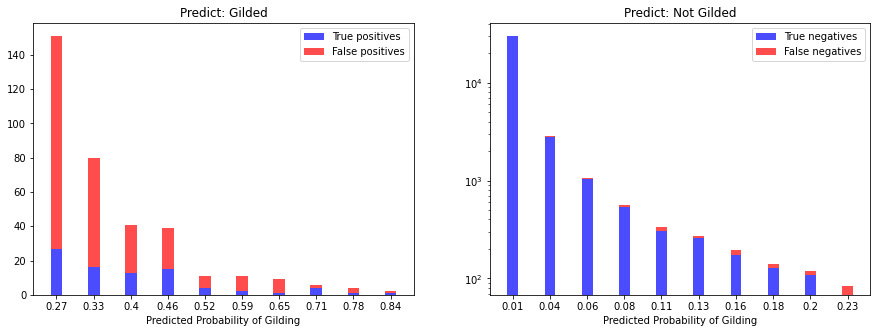

In [15]:
probas = [x[1] for x in clf.predict_proba(X_test)] 
predictions = [True if x > thresh else False for x in probas]

outcomes = pd.DataFrame({'gilded': y_test, 'predicted': predictions, 'probas': probas})
pos_outcomes = outcomes[ outcomes['predicted'] == True]
neg_outcomes = outcomes[ outcomes['predicted'] == False]

predicted_positive = (pos_outcomes
                      .groupby([pd.cut(pos_outcomes['probas'], bins=10)])
                      .sum()
                      .iloc[:,:-1]
                      .reset_index()
                     )
predicted_positive['center'] = predicted_positive['probas'].apply(lambda x: (x.left + x.right)/2)
predicted_positive['false pos'] = predicted_positive['predicted'] - predicted_positive['gilded']

predicted_negative = (neg_outcomes
                      .groupby([pd.cut(neg_outcomes['probas'], bins=10)])
                      .agg(['count', 'sum'])
                      .iloc[:,:2]
                      .reset_index()
                     )
predicted_negative['center'] = predicted_negative['probas'].apply(lambda x: (x.left + x.right)/2)
predicted_negative['true neg'] = predicted_negative[('gilded', 'count')] - predicted_negative[('gilded', 'sum')]
predicted_negative['false neg'] = predicted_negative[('gilded', 'sum')]


fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,5))
ax1.bar(predicted_positive['center'],
       predicted_positive['gilded'],
       width=0.02,
       color = 'blue',
       alpha = 0.7,
       label = 'True positives'
      )
ax1.bar(predicted_positive['center'],
       predicted_positive['false pos'], 
       bottom = predicted_positive['gilded'],
       width=0.02,
       color = 'red',
       alpha = 0.7,
       label = 'False positives'
      )
ax1.set_xticks(predicted_positive['center'])
ax1.set_xticklabels([round(x,2) for x in predicted_positive['center']])
ax1.legend(loc = 'upper right')
ax1.set_title('Predict: Gilded')
ax1.set_xlabel('Predicted Probability of Gilding')

ax2.bar(predicted_negative['center'],
       predicted_negative['true neg'],
       width=0.007,
       color = 'blue',
       alpha = 0.7,
       label = 'True negatives'
      )
ax2.bar(predicted_negative['center'],
       predicted_negative['false neg'], 
       bottom = predicted_negative['true neg'],
       width=0.007,
       color = 'red',
       alpha = 0.7,
       label = 'False negatives'
      )
ax2.set_xticks(predicted_negative['center'])
ax2.set_xticklabels([round(x,2) for x in predicted_negative['center']])
ax2.legend(loc = 'upper right')
ax2.set_yscale('log')
ax2.set_title('Predict: Not Gilded')
ax2.set_xlabel('Predicted Probability of Gilding')


plt.show()

In [16]:
def pr_from_thresh(thresh, probs, y_true):
    
    predictions = [1 if x >= thresh else 0 for x in probs]
    
    number_of_predictions = int(sum(predictions)*1e4/len(predictions))
    prec = precision_score(y_true, predictions)
    reca = recall_score(y_true, predictions)

    return prec, reca, number_of_predictions

prob_of_gilding = [x[1] for x in probs]
thresh_values = np.arange(0.05, 0.75, 0.005)
precision_recall_scores = pd.DataFrame([[x] + list(pr_from_thresh(x, prob_of_gilding, y_test)) 
                                        for x in thresh_values
                                       ],
                                       columns = ['thresh', 'precision', 'recall', 'number_of_predictions']
                                      )
precision_recall_scores['number_of_correct_predictions'] =\
precision_recall_scores.apply(lambda x: int(x['precision']*x['number_of_predictions']), axis = 1)



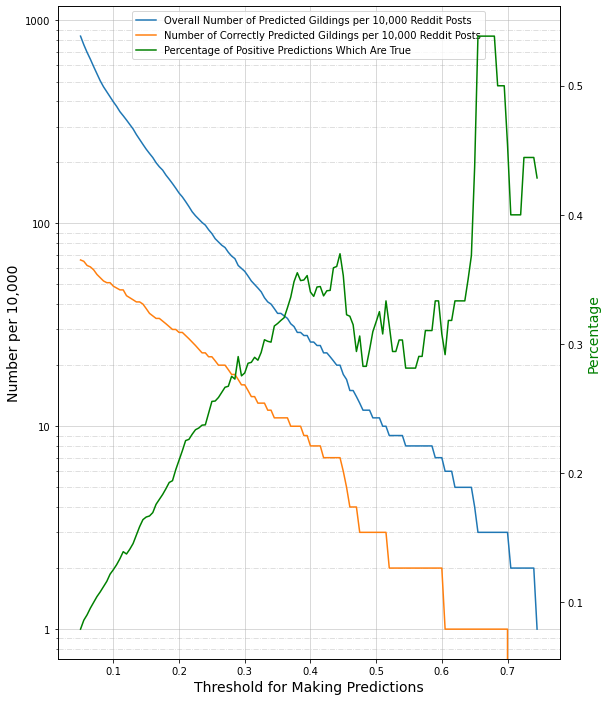

In [17]:
import matplotlib.ticker as mticker

fig, ax = plt.subplots(1,1, figsize = (9,12))

pl1 = ax.plot(precision_recall_scores['thresh'],
              precision_recall_scores['number_of_predictions'],
              label = 'Overall Number of Predicted Gildings per 10,000 Reddit Posts'
             )
pl2 = ax.plot(precision_recall_scores['thresh'],
              precision_recall_scores['number_of_correct_predictions'],
              label = 'Number of Correctly Predicted Gildings per 10,000 Reddit Posts'
             )
ax.set_xlabel('Threshold for Making Predictions', fontsize = 14)
ax.set_ylabel('Number per 10,000', fontsize = 14)
ax.set_yscale('log')
#ax.set_yticks(np.arange(0,1000,5), minor=True)
#ax.set_yticklabels([1,10,100,1000])
ax.yaxis.set_major_formatter(mticker.ScalarFormatter())

ax2 = ax.twinx()
pl3 = ax2.plot(precision_recall_scores['thresh'],
               precision_recall_scores['precision'],
               label = 'Percentage of Positive Predictions Which Are True',
               color = 'green'
             )
ax2.set_ylabel('Percentage', fontsize = 14, color = 'green')

plts = pl1 + pl2 + pl3
labels = [pl.get_label() for pl in plts]
ax.legend(plts, labels, loc=9)
ax.grid(b=True, alpha = 0.6, which = 'major')
ax.grid(b=True, alpha = 0.5, which = 'minor', linestyle = '-.')
plt.show()

In [18]:
positive_test_instances = X_test.copy()[y_test]
positive_test_instances['predicted_proba'] = [x[1] for x in clf.predict_proba(positive_test_instances)] 

negative_test_instances = X_test.copy()[~y_test]
negative_test_instances['predicted_proba'] = [x[1] for x in clf.predict_proba(negative_test_instances)] 

/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."
/mnt/f/AnacondaForUbuntu/envs/Reddit/lib/python3.7/site-packages/sklearn/utils/validation.py:509: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  "pandas.DataFrame with sparse columns found."


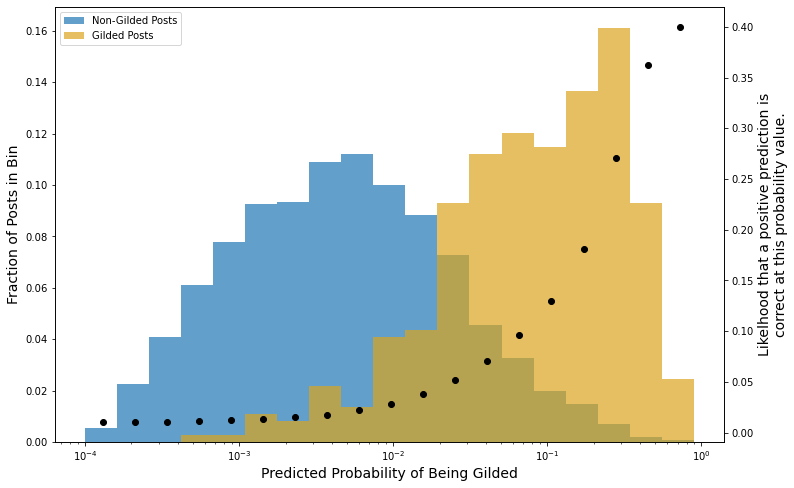

In [19]:
pos_weights = [1/positive_test_instances.shape[0]]*positive_test_instances.shape[0]
neg_weights = [1/negative_test_instances.shape[0]]*negative_test_instances.shape[0]



logbins = np.logspace(0.00001,0.8,20)

fig, ax = plt.subplots(1,1, figsize = (12,8))

bins = np.logspace(-4, -0.05, 20)
_,_,pl1 = ax.hist(negative_test_instances['predicted_proba'],
        bins = bins,
        alpha = 0.7,
        weights = neg_weights,
        label = 'Non-Gilded Posts'
       )
_,_,pl2 = ax.hist(positive_test_instances['predicted_proba'],
        bins = bins,
        alpha = 0.7, 
        weights = pos_weights,
        label = 'Gilded Posts',
        color = 'goldenrod'
       )
ax.set_xlabel('Predicted Probability of Being Gilded', fontsize = 14)
ax.set_ylabel('Fraction of Posts in Bin', fontsize = 14)
plt.legend(loc = 'upper left')
ax.set_xscale('log')

ax2 = ax.twinx()
thresh_vals = [(bins[i] + bins[i+1])/2 for i in range(len(bins)-1)]
precisions = [ pr_from_thresh(thresh, prob_of_gilding, y_test)[0] for thresh in thresh_vals]
pl3 = ax2.scatter(thresh_vals, precisions,
                  c = 'k',
                  label = 'Likelhood that a positive prediction is correct at this prediction probability value.'
                 )
ax2.set_ylabel('Likelhood that a positive prediction is\ncorrect at this probability value.', fontsize = 14)

plt.show()